In [1]:
# Import Libraries.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

## 1 Load the Dataset

In [4]:
# Load the dataset
df = pd.read_csv("Copy of Online Retail.csv",encoding='ISO-8859-1')

## 2 Understand The Data

In [7]:
# Checking first 5 rows of data 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:

# Dataset have 541909 rows and 8 columns
df.shape

(541909, 8)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [13]:
# Some statistics about numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [15]:
# Checking for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [17]:
# Missing value count in the form of Percentage(%)
round((df.isnull().sum() / len(df) ) * 100,2)  

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

## 3 Clean The Data

In [20]:
# Description column contains 0.27 % of missing values
df['Description'].astype(str).fillna('Unknown', inplace=True)

# CustomerID column contains about 25% of misssing values
df["CustomerID"].fillna(-1, inplace=True)  

In [22]:
# All missing values get handled
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [24]:
# Convert data types
df["CustomerID"] = df["CustomerID"].astype(int)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [26]:
df.duplicated().sum()

5268

In [28]:
# Remove duplicates
df.drop_duplicates(inplace=True)

## 4 Transform The Data

In [31]:
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

In [33]:
# Standardize numeric columns
df[["Quantity", "UnitPrice"]] = scaler.fit_transform(df[["Quantity", "UnitPrice"]])

In [35]:
# One-Hot Encode 'Country'
encoded_array = encoder.fit_transform(df[["Country"]])
encoded_cols = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(["Country"]))

In [37]:
# Merge with dataset
df = df.drop(columns=["Country"]).reset_index(drop=True)
df = pd.concat([df, encoded_cols], axis=1)

## 5 Feature Enigineering

In [40]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["Day"] = df["InvoiceDate"].dt.day
df["Hour"] = df["InvoiceDate"].dt.hour

In [42]:
# Create Revenue per CustomerID
df["Revenue"] = df.groupby("CustomerID")["TotalPrice"].transform("sum")

# Calculate Order Frequency per Customer
df["OrderFrequency"] = df.groupby("CustomerID")["InvoiceNo"].transform("count")

# Calculate Recency (days since last purchase)
max_date = df["InvoiceDate"].max()
df["Recency"] = (max_date - df.groupby("CustomerID")["InvoiceDate"].transform("max")).dt.days

# Drop InvoiceDate after extracting features
df.drop(columns=["InvoiceDate"], inplace=True)

In [44]:
# Feature Selection - Keep only relevant features
features = ["Revenue", "OrderFrequency", "Recency", "TotalPrice"]
X = df[features].dropna()


In [46]:
X.head()

,Revenue,OrderFrequency,Recency,TotalPrice
0,-0.019688,309,301,0.000354
1,-0.019688,309,301,0.000211
2,-0.019688,309,301,0.000143
3,-0.019688,309,301,0.000211
4,-0.019688,309,301,0.000211


In [48]:
# Standardize features
X_scaled = scaler.fit_transform(X)

In [50]:
X_scaled

array([[ 0.58655403, -0.58581393,  4.65634621,  0.02795051],
       [ 0.58655403, -0.58581393,  4.65634621,  0.02544938],
       [ 0.58655403, -0.58581393,  4.65634621,  0.02425797],
       ...,
       [ 0.58640693, -0.59022028, -0.49895947,  0.02398044],
       [ 0.58640693, -0.59022028, -0.49895947,  0.02398044],
       [ 0.58640693, -0.59022028, -0.49895947,  0.02002137]])

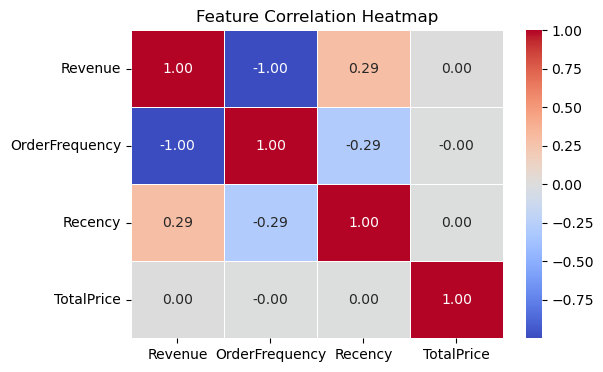

In [52]:
# Compute correlation matrix
corr_matrix = X.corr()

# Plot correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()